In [15]:
from my_vars import ROBO, MY_KEY
VIDEO1 = "/home/ubuntu/TreeHacks2025/data/videos/videos/00001.mp4" 

In [2]:
#!pip install deep-sort-realtime 
# pip install transformers torch torchvision openai 
#!pip install ultralytics opencv-python torch torchvision torchaudio easyocr numpy
#!pip install ultralytics opencv-python pillow 
#!pip install ultralytics opencv-python pandas tqdm 
# Install required libraries if not already installed
#!pip install ultralytics torch torchvision
# Fix missing dependencies for inference-sdk


# Install all required dependencies in one go
!micromamba install -n treehack inference-sdk opencv numpy requests aiohttp dataclasses-json supervision -c conda-forge -y
!pip install dataclasses-json supervision

# Verify installation
import inference_sdk
import cv2
import dataclasses_json
import supervision

print("✅ Everything installed correctly!")


zsh:1: command not found: micromamba
✅ Everything installed correctly!


In [14]:
import os
import cv2
import time
from inference_sdk import InferenceHTTPClient

# Roboflow API Setup
API_KEY = ROBO  # Load API Key securely
MODEL_ID = "lisa-bjgh5/2"  # Your YOLOv8 LISA Model ID
CLIENT = InferenceHTTPClient(api_url="https://detect.roboflow.com", api_key=API_KEY)

def detect_objects_in_frame(frame, frame_idx):
    """Detect objects in a single frame using the API."""
    frame_path = f"temp_frame_{frame_idx}.jpg"
    cv2.imwrite(frame_path, frame)

    try:
        result = CLIENT.infer(frame_path, model_id=MODEL_ID)
        frame_detections = []

        for pred in result.get("predictions", []):
            frame_detections.append({
                "frame": frame_idx,
                "label": pred["class"],
                "confidence": pred["confidence"],
                "bbox": {
                    "x": int(pred["x"]),
                    "y": int(pred["y"]),
                    "width": int(pred["width"]),
                    "height": int(pred["height"])
                }
            })

        os.remove(frame_path)  # Clean up temp frame
        return frame_detections

    except Exception as e:
        print(f"Error processing frame {frame_idx}: {e}")
        os.remove(frame_path)  # Ensure cleanup
        return []

def process_video_frames(video_path):
    """Extracts three key frames from a video and runs object detection."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = [0, total_frames // 2, total_frames - 1]  # Beginning, middle, end
    detections = []

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame {frame_idx}")
            continue

        frame_detections = detect_objects_in_frame(frame, frame_idx)
        if frame_detections:
            detections.append(frame_detections)

        time.sleep(0.2)  # Avoid API rate limits

    cap.release()
    return detections

# Example usage
detections = process_video_frames(VIDEO1)
print(detections)

print("✅ Inference complete! Detection results returned.")


[]
✅ Inference complete! Detection results returned.


How It Works
1. Extracts 8 frames from a 5-second video.
2. Encodes frames using BLIP-2’s Vision Transformer (ViT).
3. Aggregates frame embeddings (mean pooling).
4. Sends embeddings + question to ChatGPT.
5. ChatGPT generates an answer based on the video context.

In [12]:
import openai 
client = openai.OpenAI(api_key=MY_KEY) 

def generate_chatgpt_response(detected_objects):
    """
    Uses detected objects as context and queries ChatGPT-4o for a video description.
    """
    object_summary = ", ".join([f"{count} {obj}" for obj, count in detected_objects.items()])
    prompt = f"The video contains the following objects: {object_summary}. Describe what is happening in the video."

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful AI that describes video scenes based on detected objects."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=100
    )
    return response.choices[0].message.content

In [13]:
import cv2
import numpy as np
import os
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Use "yolov8m.pt" for better accuracy

# Thresholds
MIN_SHIFT_THRESHOLD = 20  # Pixels for left/right movement
FORWARD_THRESHOLD = 1.1   # 10% area increase for forward movement
UNKNOWN_THRESHOLD = 10    # Threshold for "Unknown" detection

def detect_cars_in_frame(frame, frame_num, frame_center):
    """Detect cars and return their positions."""
    results = model(frame)
    car_positions = {"left": [], "right": [], "front": []}

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = result.names[int(box.cls[0])]

            if label == "car":
                box_center_x = (x1 + x2) // 2
                width = x2 - x1
                height = y2 - y1
                area = width * height  # Box area for distance estimation

                # Categorize position
                if box_center_x < frame_center * 0.75:
                    car_positions["left"].append((box_center_x, area))
                elif box_center_x > frame_center * 1.25:
                    car_positions["right"].append((box_center_x, area))
                else:
                    car_positions["front"].append((box_center_x, area))

    return car_positions

def analyze_camera_movement(prev_data, curr_data):
    """Analyze camera movement based on object positions."""
    if not prev_data or not curr_data:
        return "Unknown"

    movement = "Unknown"

    # Get average X positions
    avg_prev_left = np.mean([x for x, _ in prev_data["left"]]) if prev_data["left"] else None
    avg_curr_left = np.mean([x for x, _ in curr_data["left"]]) if curr_data["left"] else None

    avg_prev_right = np.mean([x for x, _ in prev_data["right"]]) if prev_data["right"] else None
    avg_curr_right = np.mean([x for x, _ in curr_data["right"]]) if curr_data["right"] else None

    avg_prev_center = np.mean([x for x, _ in prev_data["front"]]) if prev_data["front"] else None
    avg_curr_center = np.mean([x for x, _ in curr_data["front"]]) if curr_data["front"] else None

    # Detect left/right movement
    if avg_prev_left and avg_curr_left and avg_curr_left > avg_prev_left + MIN_SHIFT_THRESHOLD:
        movement = "Moving Right"
    elif avg_prev_right and avg_curr_right and avg_curr_right < avg_prev_right - MIN_SHIFT_THRESHOLD:
        movement = "Moving Left"

    # Detect forward movement
    prev_avg_area = np.mean([area for _, area in prev_data["front"]]) if prev_data["front"] else None
    curr_avg_area = np.mean([area for _, area in curr_data["front"]]) if curr_data["front"] else None

    if prev_avg_area and curr_avg_area:
        if curr_avg_area > prev_avg_area * FORWARD_THRESHOLD:
            movement = "Moving Forward"

    # Strengthen "Unknown" detection
    if movement in ["Moving Left", "Moving Right", "Moving Forward"]:
        if avg_curr_center is None or avg_prev_center is None or abs(avg_curr_center - avg_prev_center) < UNKNOWN_THRESHOLD:
            movement = "Unknown"

    # Distance estimation
    car_summary = {
        "Left": {"Close": sum(1 for _, area in curr_data["left"] if area > 50000),
                 "Far": sum(1 for _, area in curr_data["left"] if area <= 50000)},
        "Right": {"Close": sum(1 for _, area in curr_data["right"] if area > 50000),
                  "Far": sum(1 for _, area in curr_data["right"] if area <= 50000)},
        "Front": {"Close": sum(1 for _, area in curr_data["front"] if area > 50000),
                  "Far": sum(1 for _, area in curr_data["front"] if area <= 50000)}
    }

    return movement, car_summary

def process_video_frames(video_path):
    """Extracts 8 frames from a video and analyzes movement."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_center = frame_width // 2

    frame_indices = np.linspace(0, total_frames - 1, 8).astype(int).tolist()
    prev_frame_data = None
    movement_summary = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame {idx}")
            continue

        curr_frame_data = detect_cars_in_frame(frame, idx, frame_center)

        if prev_frame_data is not None:
            movement, car_info = analyze_camera_movement(prev_frame_data, curr_frame_data)
            movement_summary.append((idx, movement, car_info))

        prev_frame_data = curr_frame_data

    cap.release()

    # Print movement analysis
    for frame, movement, cars in movement_summary:
        print(f"Frame {frame}: {movement} | Cars -> Left: {cars['Left']}, Right: {cars['Right']}, Front: {cars['Front']}")

    return movement_summary

# Example usage
movement_summary = process_video_frames(VIDEO1)
print("✅ Detection complete! Results returned.")



0: 416x640 4 cars, 3.4ms
Speed: 1.9ms preprocess, 3.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 3 cars, 3.7ms
Speed: 1.8ms preprocess, 3.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 5 cars, 3.6ms
Speed: 1.6ms preprocess, 3.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 8 cars, 3.7ms
Speed: 1.6ms preprocess, 3.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 7 cars, 3.7ms
Speed: 1.6ms preprocess, 3.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 7 cars, 3.6ms
Speed: 1.6ms preprocess, 3.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 7 cars, 1 fire hydrant, 3.6ms
Speed: 1.6ms preprocess, 3.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 9 cars, 1 truck, 3.6ms
Speed: 1.5ms preprocess, 3.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


0: 416x640 4 cars, 3.3ms
Speed: 1.7ms preprocess, 3.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


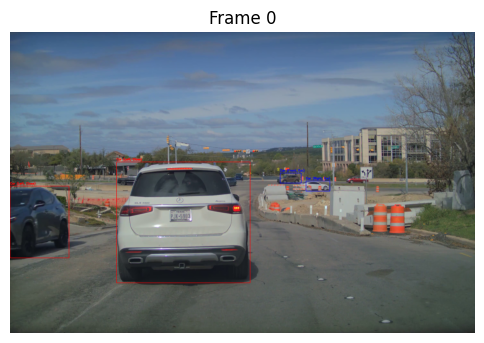


0: 416x640 3 cars, 3.7ms
Speed: 1.6ms preprocess, 3.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


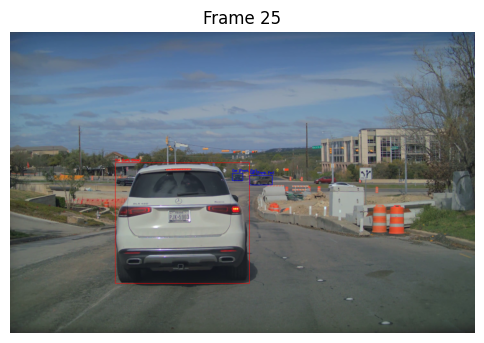


0: 416x640 5 cars, 4.5ms
Speed: 1.7ms preprocess, 4.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


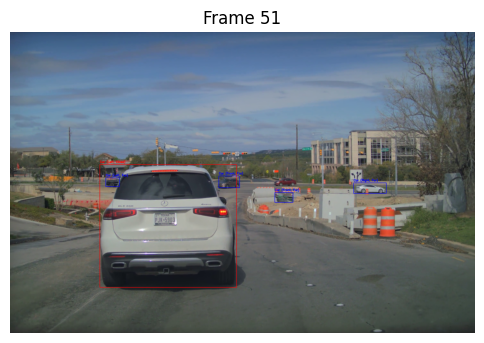


0: 416x640 8 cars, 3.6ms
Speed: 1.8ms preprocess, 3.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


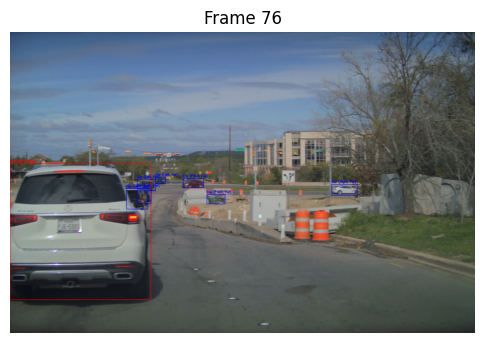


0: 416x640 7 cars, 3.7ms
Speed: 1.9ms preprocess, 3.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


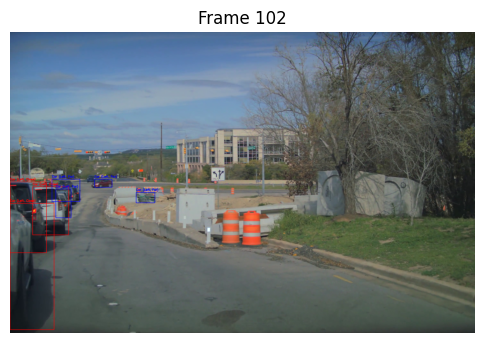


0: 416x640 7 cars, 6.1ms
Speed: 2.5ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


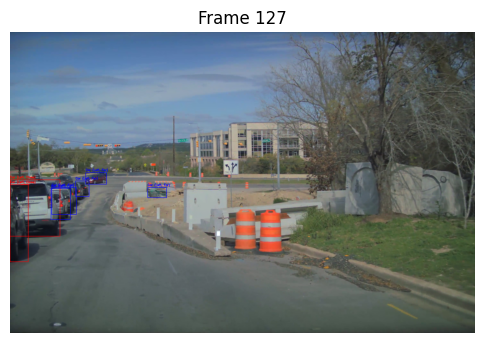


0: 416x640 7 cars, 1 fire hydrant, 3.7ms
Speed: 1.7ms preprocess, 3.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


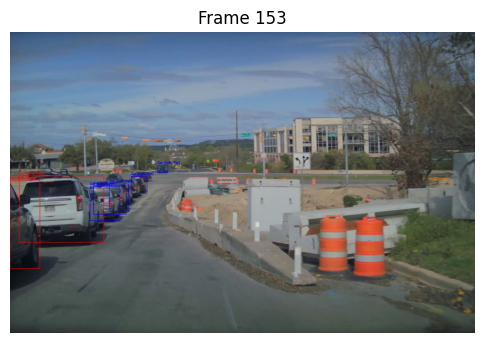


0: 416x640 9 cars, 1 truck, 3.7ms
Speed: 1.5ms preprocess, 3.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


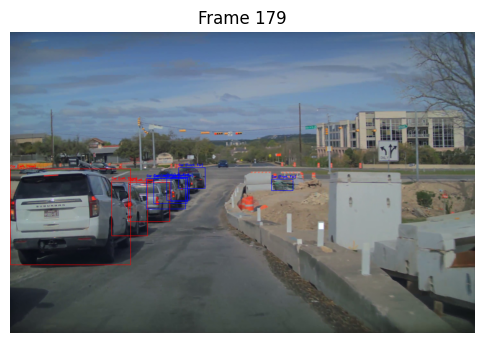

Frame 25: Moving Right | Cars -> Left: {'Close': 1, 'Far': 0}, Right: {'Close': 0, 'Far': 0}, Front: {'Close': 0, 'Far': 2}
Frame 51: Moving Forward | Cars -> Left: {'Close': 1, 'Far': 1}, Right: {'Close': 0, 'Far': 1}, Front: {'Close': 0, 'Far': 2}
Frame 76: Moving Left | Cars -> Left: {'Close': 1, 'Far': 4}, Right: {'Close': 0, 'Far': 1}, Front: {'Close': 0, 'Far': 2}
Frame 102: Unknown | Cars -> Left: {'Close': 3, 'Far': 4}, Right: {'Close': 0, 'Far': 0}, Front: {'Close': 0, 'Far': 0}
Frame 127: Unknown | Cars -> Left: {'Close': 2, 'Far': 5}, Right: {'Close': 0, 'Far': 0}, Front: {'Close': 0, 'Far': 0}
Frame 153: Unknown | Cars -> Left: {'Close': 2, 'Far': 5}, Right: {'Close': 0, 'Far': 0}, Front: {'Close': 0, 'Far': 0}
Frame 179: Unknown | Cars -> Left: {'Close': 3, 'Far': 4}, Right: {'Close': 0, 'Far': 0}, Front: {'Close': 0, 'Far': 2}
✅ Detection complete! Processed frames displayed and saved.


'\n    cap = cv2.VideoCapture(video_path)\n    detected_signs = Counter()\n    sign_texts = []\n\n    while cap.isOpened():\n        ret, frame = cap.read()\n        if not ret:\n            break\n\n        results = sign_model(frame)  # 🔥 Run Traffic Sign Model\n        for result in results:\n            for box in result.boxes:\n                class_id = int(box.cls[0].item())\n                obj_name = sign_model.names[class_id]\n\n                if obj_name in TRAFFIC_SIGN_CLASSES:\n                    detected_signs[obj_name] += 1\n                    \n                    # 🔍 Extract text from sign\n                    x1, y1, x2, y2 = box.xyxy[0].int().tolist()\n                    sign_region = frame[y1:y2, x1:x2]  # Crop sign\n                    sign_text = ocr_reader.readtext(sign_region, detail=0)  # Read text\n\n                    if sign_text:\n                        sign_texts.append((obj_name, " ".join(sign_text)))  # Save sign + text\n\n    cap.release()\n    re

In [18]:
# FOR SHOWING THE IMAGES: 
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # You can use "yolov8m.pt" for better accuracy

# Load video
video_path = VIDEO1  # Use predefined VIDEO1 variable
cap = cv2.VideoCapture(video_path)

# Create output directory
output_dir = "processed_frames"
os.makedirs(output_dir, exist_ok=True)

# Get video properties
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_center = frame_width // 2  # Middle of the frame

# Select 8 evenly spaced frames
frame_indices = np.linspace(0, total_frames - 1, 8).astype(int).tolist()

# Store detected object positions
object_positions = {}
prev_frame_data = None  # Store previous frame's detection data

# Thresholds
MIN_SHIFT_THRESHOLD = 20  # Pixels required for detecting left/right movement
FORWARD_THRESHOLD = 1.1   # 10% area increase for forward movement
UNKNOWN_THRESHOLD = 10    # Strengthened "Unknown" detection

def detect_cars(frame, frame_num):
    """Detect cars and track their positions."""
    results = model(frame)
    car_positions = {"left": [], "right": [], "front": []}
    total_x_positions = []  # To estimate left/right movement
    total_areas = []  # To estimate forward movement

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = result.names[int(box.cls[0])]
            box_center_x = (x1 + x2) // 2
            width = x2 - x1
            height = y2 - y1
            area = width * height  # Box area for motion detection

            if label == "car":  # Only process car detections
                total_x_positions.append(box_center_x)
                total_areas.append(area)

                # Categorize cars based on position in the frame
                if box_center_x < frame_center * 0.75:
                    position = "Left"
                    car_positions["left"].append((box_center_x, area))
                elif box_center_x > frame_center * 1.25:
                    position = "Right"
                    car_positions["right"].append((box_center_x, area))
                else:
                    position = "Front"
                    car_positions["front"].append((box_center_x, area))

                # Estimate distance (Close or Far)
                distance = "Close" if area > 50000 else "Far"

                # Draw bounding box and label
                color = (0, 0, 255) if distance == "Close" else (255, 0, 0)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, f"Car ({position}, {distance})", 
                            (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Store detected objects for motion analysis
    object_positions[frame_num] = car_positions

    # Save processed frame
    output_path = os.path.join(output_dir, f"frame_{frame_num}.jpg")
    cv2.imwrite(output_path, frame)

    # Display frame
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Frame {frame_num}")
    plt.show()

    return car_positions

def analyze_camera_movement(prev_data, curr_data):
    """Analyze camera movement using only the previous frame."""
    if prev_data is None or curr_data is None:
        return "Unknown"

    movement = "Unknown"

    # Get average X positions of objects in each region
    avg_prev_left = np.mean([x for x, _ in prev_data["left"]]) if prev_data["left"] else None
    avg_curr_left = np.mean([x for x, _ in curr_data["left"]]) if curr_data["left"] else None

    avg_prev_right = np.mean([x for x, _ in prev_data["right"]]) if prev_data["right"] else None
    avg_curr_right = np.mean([x for x, _ in curr_data["right"]]) if curr_data["right"] else None

    avg_prev_center = np.mean([x for x, _ in prev_data["front"]]) if prev_data["front"] else None
    avg_curr_center = np.mean([x for x, _ in curr_data["front"]]) if curr_data["front"] else None

    # Left/right movement detection
    if avg_prev_left and avg_curr_left and avg_curr_left > avg_prev_left + MIN_SHIFT_THRESHOLD:
        movement = "Moving Right"
    elif avg_prev_right and avg_curr_right and avg_curr_right < avg_prev_right - MIN_SHIFT_THRESHOLD:
        movement = "Moving Left"

    # Forward detection (More lenient)
    prev_avg_area = np.mean([area for _, area in prev_data["front"]]) if prev_data["front"] else None
    curr_avg_area = np.mean([area for _, area in curr_data["front"]]) if curr_data["front"] else None

    if prev_avg_area and curr_avg_area:
        if curr_avg_area > prev_avg_area * FORWARD_THRESHOLD:  # Only 10% increase to detect forward
            movement = "Moving Forward"

    # Strengthen "Unknown" detection
    if movement in ["Moving Left", "Moving Right", "Moving Forward"]:
        if avg_curr_center is None or avg_prev_center is None or abs(avg_curr_center - avg_prev_center) < UNKNOWN_THRESHOLD:
            movement = "Unknown"

    # Distance estimation
    car_summary = {
        "Left": {"Close": sum(1 for _, area in curr_data["left"] if area > 50000),
                 "Far": sum(1 for _, area in curr_data["left"] if area <= 50000)},
        "Right": {"Close": sum(1 for _, area in curr_data["right"] if area > 50000),
                  "Far": sum(1 for _, area in curr_data["right"] if area <= 50000)},
        "Front": {"Close": sum(1 for _, area in curr_data["front"] if area > 50000),
                  "Far": sum(1 for _, area in curr_data["front"] if area <= 50000)}
    }

    return movement, car_summary

# Process selected frames
prev_frame_data = None
movement_summary = []

for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame {idx}")
        continue

    curr_frame_data = detect_cars(frame, idx)

    if prev_frame_data is not None:
        movement, car_info = analyze_camera_movement(prev_frame_data, curr_frame_data)
        movement_summary.append((idx, movement, car_info))

    prev_frame_data = curr_frame_data  # Update previous frame data

cap.release()
cv2.destroyAllWindows()

# Print movement analysis
for frame, movement, cars in movement_summary:
    print(f"Frame {frame}: {movement} | Cars -> Left: {cars['Left']}, Right: {cars['Right']}, Front: {cars['Front']}")

print("✅ Detection complete! Processed frames displayed and saved.")

"""
OLD TECH
 import torch
import cv2
import easyocr
from ultralytics import YOLO
from collections import Counter

# Use a better model like "yolov8m.pt" or "yolov8l.pt" for more accuracy
sign_model = YOLO("yolov8l.pt")  # 🔥 Using a larger YOLO model for better sign detection

# 🚦 Define Traffic Sign Classes (Custom Dataset Needed for More Accuracy)
TRAFFIC_SIGN_CLASSES = ["stop sign", "speed limit sign", "parking sign", "warning sign",
                         "one way sign", "exit sign", "airport sign", "construction sign", "yield sign"]

# 📖 OCR Model (For extracting text from traffic signs)
ocr_reader = easyocr.Reader(['en'])

def detect_traffic_signs(video_path):
    """
"""
    cap = cv2.VideoCapture(video_path)
    detected_signs = Counter()
    sign_texts = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = sign_model(frame)  # 🔥 Run Traffic Sign Model
        for result in results:
            for box in result.boxes:
                class_id = int(box.cls[0].item())
                obj_name = sign_model.names[class_id]

                if obj_name in TRAFFIC_SIGN_CLASSES:
                    detected_signs[obj_name] += 1
                    
                    # 🔍 Extract text from sign
                    x1, y1, x2, y2 = box.xyxy[0].int().tolist()
                    sign_region = frame[y1:y2, x1:x2]  # Crop sign
                    sign_text = ocr_reader.readtext(sign_region, detail=0)  # Read text

                    if sign_text:
                        sign_texts.append((obj_name, " ".join(sign_text)))  # Save sign + text

    cap.release()
    return detected_signs, sign_texts

# 🚀 Example Usage
VIDEO1 = VIDEO1

detected_signs, sign_texts = detect_traffic_signs(VIDEO1)

# 📊 Print Results
print(f"🛑 Traffic Signs Detected: {dict(detected_signs)}")
print(f"📖 Extracted Text from Signs: {sign_texts}")
"""

2. Fine-Tuning BLIP-2 for Video Question Answering
Objective: Teach BLIP-2 to process ego-centric video frames and answer driving-related questions.